# Introduction
Hello people, welcome to this kernel. In this kernel I am going to generate some new van gogh paintings using van gogh paintings dataset and natural images dataset.

Before starting, let's take a look at the content of this kernel

# Notebook Content
1. Importing Necessary Libraries
1. Loading Data
1. Building Generator Model
1. Building Discriminator Model
1. Building CycleGAN Model
1. Defining Optimizers and Loss Functions
1. Training Model
1. Generating Some Paintings
1. Conclusion

# Importing Necessary Libraries
In this section I am going to import libraries that I will use.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

import cv2 
from glob import glob
import os

# Loading Dataset
In this section I am going to load images.

In [2]:
main_path = "../input/van-gogh-paintings"
style_img_paths = []
for class_path in [os.path.join(main_path,class_name) for class_name in os.listdir(main_path)]:
    
    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        style_img_paths.append(class_img_path)

print("There are {} style images in Van Gogh Paintings Dataset".format(len(style_img_paths)))

There are 2025 style images in Van Gogh Paintings Dataset


In [3]:
main_path = "../input/natural-images/natural_images"
normal_image_paths = []
for class_path in [os.path.join(main_path,class_name) for class_name in os.listdir(main_path)]:
    
    class_img_paths = glob(class_path+"/*")
    for class_img_path in class_img_paths:
        normal_image_paths.append(class_img_path)

print("There are {} natural images in the Natural Images Dataset".format(len(normal_image_paths)))

There are 6899 natural images in the Natural Images Dataset


* We've determined paths of images, now we can read them.

In [4]:
style_images = []
normal_images = []

for style_path in style_img_paths:
    img = cv2.imread(style_path)
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    style_images.append(img)
    
for normal_path in normal_image_paths:
    img = cv2.imread(normal_path)
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    normal_images.append(img)
    
print(len(style_images))
print(len(normal_images))

2025
6899


In [5]:
# converting to float32 
style_images = np.array(style_images,dtype=np.float32)
normal_images = np.array(normal_images,dtype=np.float32)

# scaling between -1 and 1
style_images = style_images / 127.5 - 1
normal_images = normal_images / 127.5 - 1

# batching
style_images = tf.data.Dataset.from_tensor_slices(style_images).batch(1)
normal_images = tf.data.Dataset.from_tensor_slices(normal_images).batch(1)

* Our images are ready, let's check them.

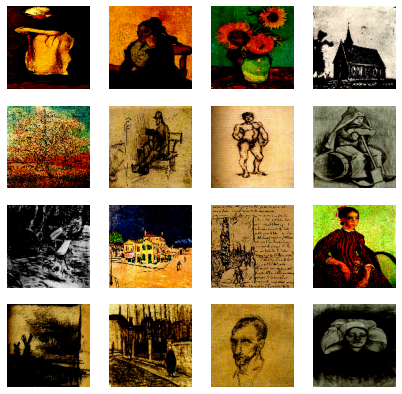

In [6]:
plt.figure(figsize=(7,7))
plt.title("Style Images")
for i,image in enumerate(style_images.shuffle(10000).take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0])
    plt.axis("off")
plt.show()

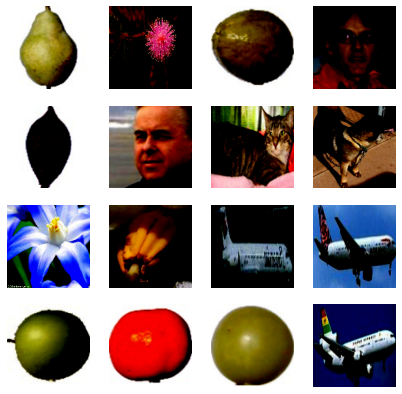

In [7]:
plt.figure(figsize=(7,7))
plt.title("Natural Images")
for i,image in enumerate(normal_images.shuffle(10000).take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0])
    plt.axis("off")
plt.show()

# Building Generator Model
In this section I am going to build the generator networks of the CycleGAN.

In [8]:
# we need to downsample and upsample the images, so let's write two new layers, Upsample layer and Downsample Layer
OUTPUT_CHANNELS = len(["Red","Green","Blue"])

def downsample(filters,size,apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    return result

* Thanks to this layers, we can easily create our generator and discriminator.

In [9]:
# discriminator

def Generator():
    inputs = layers.Input([128,128,3])
    
    down_stack = [downsample(128,4), # 64x64x128
                  downsample(256,4), # 32x32x256
                  downsample(512,4), # 16x16x512
                  downsample(512,4), # 8x8x512
                  downsample(512,4), # 4x4x512
                  downsample(512,4), # 2x2x512
                  downsample(512,4), # 1x1x512
                 ]
    
    up_stack = [upsample(512,4,apply_dropout=True), # 2x2
                upsample(512,4,apply_dropout=True), # 4x4
                upsample(512,4), # 8x8
                upsample(256,4), # 16x16
                upsample(128,4), # 32x32
                upsample(64,4),  # 64x64
               ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    
    # we'll create skip connections like a residual network
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs,outputs=x)

* Generator is a bit confusing, I know.
1. First, generator took 128x128x3 image (this will be our natural image) and converted it into 1x1x512 vector.
1. Then, upsampled that vector to 128x128x3
1. We created skip connections, they will prevent vanishing gradient problem.
1. And finally we returned our model.

# Building Discriminator Model
In this section I am going to build the discriminator model. This will be easier, because Discriminator is a CNN based classifier. It determines whether image is real or generated.


In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    inp = layers.Input([128,128,3],name="input_image")
    
    x = inp
    
    down1 = downsample(64,4,False)(x) # 64x64x64
    down2 = downsample(128,4,False)(down1) # 32x32x128
    
    zero_pad1 = layers.ZeroPadding2D()(down2)
    
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=inp,outputs=last)

    

* Our functions are ready, now we can create our generators and discriminators.

In [11]:
vangogh_generator = Generator() # generates van gogh paintings using natural images
photo_generator = Generator() # generates natural images using van gogh paintings

vangogh_discriminator = Discriminator() # determines whether van gogh painting is real or generated
photo_discriminator = Discriminator() # determines whether natural image is real or generated

# Building CycleGAN Model
In this section I am going to build CycleGAN model using our generators and discriminators.

I will create a new class by inheriting the model class.

In [12]:
class CycleGAN(keras.Model):
    
    def __init__(self,
                 vangogh_generator,
                 photo_generator,
                 vangogh_discriminator,
                 photo_discriminator,
                 lambda_cycle = 10,
                ):
        super(CycleGAN,self).__init__()
        self.v_gen = vangogh_generator
        self.p_gen = photo_generator
        self.v_disc = vangogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    
    def compile(self,
                v_gen_optimizer,
                p_gen_optimizer,
                p_disc_optimizer,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn,
                v_disc_optimizer
               ):
        super(CycleGAN,self).compile()
        self.v_gen_optimizer = v_gen_optimizer
        self.p_gen_optimizer =  p_gen_optimizer
        self.v_disc_optimizer  = v_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.p_disc_optimizer = p_disc_optimizer
        
    
    def train_step(self,batch_data):
        real_vangogh,real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to vangogh back to photo
            fake_vangogh = self.v_gen(real_photo,training=True)
            cycled_photo = self.p_gen(fake_vangogh,training=True)
            
            # vangogh to photo back to vangogh
            fake_photo = self.p_gen(real_vangogh,training=True)
            cycled_vangogh = self.v_gen(fake_photo,training=True)
            
            # generating itself
            same_photo = self.p_gen(real_photo,training=True)
            same_vangogh = self.v_gen(real_vangogh,training=True)
            
            # checking images using discriminator
            disc_real_vangogh = self.v_disc(real_vangogh,training=True)
            disc_real_photo = self.p_disc(real_photo,training=True)
            
            disc_fake_vangogh = self.v_disc(fake_vangogh,training=True)
            disc_fake_photo = self.p_disc(fake_photo,training=True)
            
            # computing generator loss
            vangogh_gen_loss = self.gen_loss_fn(disc_fake_vangogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # computing total cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_vangogh,cycled_vangogh,self.lambda_cycle) + self.cycle_loss_fn(real_photo,cycled_photo,self.lambda_cycle)
            
            # computing total loss
            total_vangogh_gen_loss = vangogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vangogh, same_vangogh, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # computing discriminator loss
            vangogh_disc_loss = self.disc_loss_fn(disc_real_vangogh,disc_fake_vangogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo,disc_fake_photo)
            
        
        # calculating gradients of networks
        vangogh_generator_gradients = tape.gradient(total_vangogh_gen_loss,self.v_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
        
        vangogh_discriminator_gradients = tape.gradient(vangogh_disc_loss,self.v_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)
        
        self.v_gen_optimizer.apply_gradients(zip(vangogh_generator_gradients,self.v_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        
        self.v_disc_optimizer.apply_gradients(zip(vangogh_discriminator_gradients,
                                                  self.v_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "v_gen_loss": total_vangogh_gen_loss,
            "p_gen_loss": total_photo_gen_loss,
            "v_disc_loss": vangogh_disc_loss,
            "p_disc_loss": photo_disc_loss
        }
        
        

I know, training looks a bit confusing but don't worry, I will explain
1. First we created fake photos, same photos, and cycled photos, we'll use them in order to compute loss
1. Then we computed losses, we'll use these losses in order to compute gradients
1. Then we computed gradients and applied it to networks.


# Defining Optimizers And Loss Functions
In this section I am going to define optimizers and loss functions.

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
def discriminator_loss(real,generated):
    
    real_loss = cross_entropy(tf.ones_like(real),real)
    generated_loss = cross_entropy(tf.zeros_like(generated),generated)
    
    total_loss = real_loss + generated_loss
    
    return total_loss * 0.5
    

In discriminator loss, we've computed real images loss and generated images loss and added them.

In [14]:
def generator_loss(generated):
    
    return cross_entropy(tf.ones_like(generated),generated)


* But when it comes to compute generator loss, we just use generated (fake) images loss.

In [15]:
def cycle_loss(real_image,cycled_image,LAMBDA):
    
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

def identity_loss(real_image,same_image,LAMBDA):
    
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA

In [16]:
# We'll use Adam optimizer
vangogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

vangogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training Model
In this section I am going to train our CycleGAN model.

In [17]:
model = CycleGAN(vangogh_generator=vangogh_generator,
                photo_generator=photo_generator,
                vangogh_discriminator=vangogh_discriminator,
                photo_discriminator=photo_discriminator
                )

model.compile(v_gen_optimizer=vangogh_generator_optimizer,
              p_gen_optimizer=photo_generator_optimizer,
              p_disc_optimizer=photo_discriminator_optimizer,
              v_disc_optimizer=vangogh_discriminator_optimizer,
              gen_loss_fn=generator_loss,
              disc_loss_fn=discriminator_loss,
              cycle_loss_fn=cycle_loss,
              identity_loss_fn=identity_loss
             )



* We created our model, let's fit it for 25 epochs.

In [27]:
#if os.path.exists("./model.h5"):
    #model.load_weights("./model.h5")
    #print("Saved weigths loaded")


model.fit(tf.data.Dataset.zip((style_images,normal_images)),
          epochs=2)

model.save_weights("model.h5")

Epoch 1/2
2025/2025 [==============================] - 400s 197ms/step - monet_gen_loss: 6.4424 - photo_gen_loss: 6.6122 - monet_disc_loss: 0.5631 - photo_disc_loss: 0.5545
Epoch 2/2
2025/2025 [==============================] - 399s 197ms/step - monet_gen_loss: 6.0495 - photo_gen_loss: 6.2233 - monet_disc_loss: 0.5486 - photo_disc_loss: 0.5414


* I've trained for 4 epoch, each epoch takes 6 minutes.
* If you try to train 10 epochs, it will be better.

# Generating Some Paintings
In this section I am going to generate some paintings.

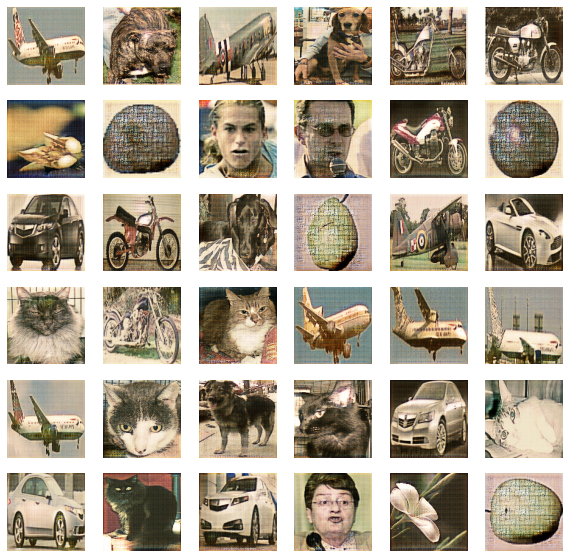

In [29]:

plt.figure(figsize=(10,10))
for i,image in enumerate(normal_images.shuffle(10000).take(36)):
    plt.subplot(6,6,i+1)
    prediction = vangogh_generator(image,training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(X = prediction)
    plt.axis("off")
    if i==36:
        break
plt.show()

* Our model works right, but it needs to train more.


# Conclusion
Thanks for your attention, if you have any questions in your mind, please ask. I will definetely return.